In [2]:
import numpy as np
import scipy as sp
import chemiscope
import featomic
import ase.io
from tqdm import tqdm
import metatensor.operations as mto
from metatensor import Labels
import matplotlib.pyplot as plt

# Time correlations

In [3]:
stride = 4
frames = ase.io.read("/Users/markusfasching/EPFL/Work/project-SOAP/scripts/SOAP-time-code/data/GeTe/ramp_up.pos_0.extxyz", "1000:")[::stride] + ase.io.read("/Users/markusfasching/EPFL/Work/project-SOAP/scripts/SOAP-time-code/data/GeTe/ramp_down.pos_0.extxyz", ":-500")[::stride]
for f in frames:
    f.wrap()

In [16]:
# hypers for evaluating features
hypers = {
    "cutoff": {"radius": 5, "smoothing": {"type": "ShiftedCosine", "width": 8}},
    "density": {"type": "Gaussian", "width": 2.0},
    "basis": {
        "type": "TensorProduct",
        "max_angular": 6,
        "radial": {"type": "Gto", "max_radial": 6},
    },
}
# gets only Te-centered features
selection = Labels(
    names=["center_type"],
    values=np.array([[52]], dtype=np.int32),
)
calculator = featomic.SoapPowerSpectrum(**hypers)

In [17]:
rho2i_0 = calculator.compute(frames[0]) # , selected_keys=selection)
rho2i_0 = rho2i_0.keys_to_samples(["center_type"]).keys_to_properties(
    ["neighbor_1_type", "neighbor_2_type"]
)
rho2i_values = rho2i_0.block(0).values
print(rho2i_values.shape)

(512, 1029)


In [18]:
len(frames[0])

512

In [57]:
maxlag=7
atomsel=np.arange(0,len(frames[0]),25) # selects only a few atoms so it fits into memory
ige = np.arange(len(atomsel)//2)
ite = ige+(len(atomsel)//2)

In [58]:
buffer = np.zeros((len(atomsel),maxlag,rho2i_values.shape[1]))
corrcov = np.zeros((2, maxlag, rho2i_values.shape[1],rho2i_values.shape[1],))
soapsum = np.zeros((2 ,rho2i_values.shape[1],))

In [62]:
nsmp = 0
print('ige', ige)
print('ite', ite)
for fidx, frame in tqdm(enumerate(frames), total=len(frames)):
    
    # COMPUTE THE SOAP POWER SPECTRUM, COEFFS OF SPHERICAL EXPANSION
    rho2i = calculator.compute(frame) # , selected_keys=selection)
    rho2i = rho2i.keys_to_samples(["center_type"]).keys_to_properties(
        ["neighbor_1_type", "neighbor_2_type"]
    )
    new_soap = rho2i.block(0).values[atomsel]
    
    #print('newsoap', new_soap.shape)
    # CHECK IF ITS OUTSIDE OF LAG
    
    if fidx>=maxlag:
        #print('fidx', fidx)
        # SHIFT FIRST 
        #print('new index in buffer', fidx%maxlag)
        #print('beffirst')
        first = buffer[:,fidx%maxlag] # the previous soap is first now
        roll_idx = np.roll(np.arange(maxlag), -fidx%maxlag) # choose lag to be the relative position in the current lag buffer
        #print('afterroll')
        #print('roll index', roll_idx)
        # computes a contribution to the correlation function
        # the buffer contains data from fidx-maxlag to fidx. add a forward ACF
        print(fidx%maxlag)
        print(roll_idx)
        newcov = np.einsum("ia,ijb->jab", first[ige], buffer[ige][:,roll_idx]) 
        #print('einsum1')
        #summing over different atoms i, cross correlating soap comp a at t=0 and b at all t=0, lagmax
        corrcov[0] += newcov
        newcov = np.einsum("ia,ijb->jab", first[ite], buffer[ite][:,roll_idx])
        #print('einsum2')
        corrcov[1] += newcov
        
        soapsum[0] += first[ige].sum(axis=0) # sum over all atoms, for the first lag, each SOAP comp?
        soapsum[1] += first[ite].sum(axis=0)
        
        nsmp += len(ige) # total number of atoms * samples --> 
        
    buffer[:,fidx%maxlag] = new_soap # move the previous soap to the start of buffer

ige [0 1 2 3 4 5 6 7 8 9]
ite [10 11 12 13 14 15 16 17 18 19]


  0%|          | 6/1627 [00:01<03:33,  7.58it/s]

0
[0 1 2 3 4 5 6]


  0%|          | 8/1627 [00:02<08:58,  3.01it/s]

1
[1 2 3 4 5 6 0]


  1%|          | 9/1627 [00:02<11:21,  2.37it/s]

2
[2 3 4 5 6 0 1]


  1%|          | 10/1627 [00:03<13:07,  2.05it/s]

3
[3 4 5 6 0 1 2]


  1%|          | 11/1627 [00:04<14:58,  1.80it/s]

4
[4 5 6 0 1 2 3]


  1%|          | 12/1627 [00:04<15:32,  1.73it/s]

5
[5 6 0 1 2 3 4]


  1%|          | 13/1627 [00:05<15:55,  1.69it/s]

6
[6 0 1 2 3 4 5]


  1%|          | 14/1627 [00:06<16:13,  1.66it/s]

0
[0 1 2 3 4 5 6]


  1%|          | 15/1627 [00:06<12:25,  2.16it/s]


KeyboardInterrupt: 

In [23]:
# autocorrelation matrix - remove mean (sum of all soaps / amount if frames and atoms)
corrcc = corrcov/nsmp - soapsum[:, None, :, None]* soapsum[:, None, None, :]/(nsmp**2)

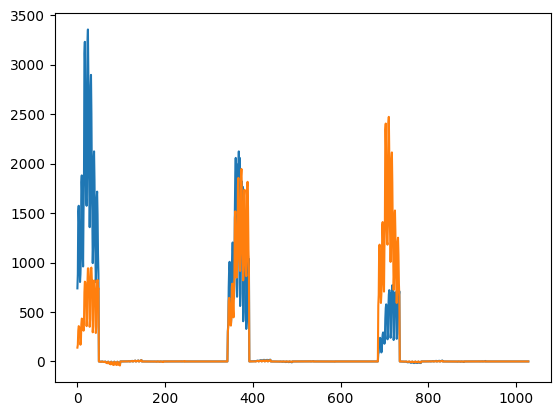

In [24]:
plt.plot(soapsum[0])
plt.plot(soapsum[1])

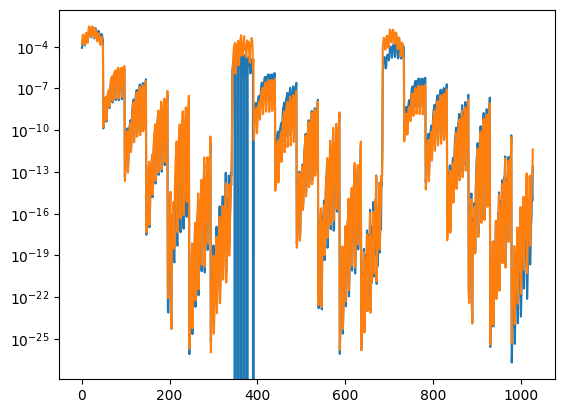

In [25]:
plt.semilogy(np.diagonal(corrcc[0,-1]))
plt.semilogy(np.diagonal(corrcc[1,-1]))

In [ ]:
# autocorrelation matrix - normalize
#for iat in range(len(atomsel)):
#    nrm = np.sqrt(np.diagonal(corrcc[0,iat]))
#    corrcc[:,iat] /= (nrm[:, None]*nrm[None,:])[None, :, :]

In [26]:
tau_min = 25 
tau_max = 75

In [27]:
sigma = corrcc[:,tau_min:tau_max,:,:].sum(axis=1)
sigma0 = corrcc[:, 0]

In [28]:
for i in range(10):
    plt.plot(allevatau[0,:,-i])

NameError: name 'allevatau' is not defined

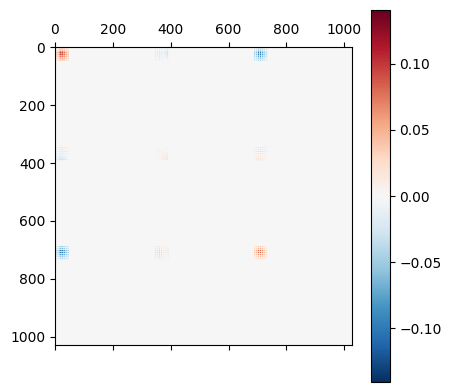

In [29]:
vmax = np.max(np.abs(sigma[1]))
cax = plt.matshow(sigma[1], cmap='RdBu_r', vmin=-vmax, vmax=vmax)
plt.colorbar(cax)

In [30]:
alleva, alleve = [None, None], [None, None]
for i in range(2):
    alleva[i], alleve[i] = sp.linalg.eigh(0.5*(sigma[i]+sigma[i].T), 
                                0.5*(sigma0[i]+sigma0[i].T)
                                +np.eye(len(sigma0[i]))*1e-5)
alleva = np.array(alleva)
alleve = np.array(alleve)

LinAlgError: The leading minor of order 26 of B is not positive definite. The factorization of B could not be completed and no eigenvalues or eigenvectors were computed.

(100, 1029, 1029)


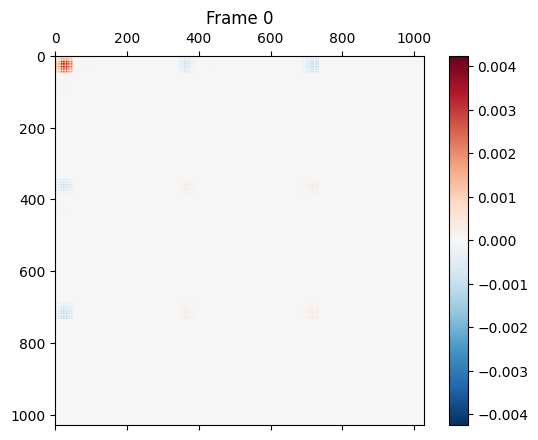

interactive(children=(IntSlider(value=0, description='Frame', max=99), Output()), _dom_classes=('widget-intera…

<function __main__.update(frame)>

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
print(corrcc[0].shape)

# Set up the figure and axis
fig, ax = plt.subplots()
vmax = np.max(np.abs(corrcc[0]))
cax = ax.matshow(corrcc[0][0], cmap='RdBu_r', vmin=-vmax, vmax=vmax)
plt.colorbar(cax, ax=ax)
title = ax.set_title("Frame 0")

# Define slider widget
slider = widgets.IntSlider(value=0, min=0, max=maxlag-1, step=1, description='Frame')

# Update function
def update(frame):
    cax.set_data(corrcc[0][frame])
    title.set_text(f"Frame {frame}")
    fig.canvas.draw_idle()

# Link slider to update function
widgets.interact(update, frame=slider)

In [32]:
allevatau, allevetau = np.zeros((corrcc.shape[0], corrcc.shape[1], corrcc.shape[2])), np.zeros(corrcc.shape)
for i in range(2):
    for j in range(maxlag):
        allevatau[i][j], allevetau[i][j] = sp.linalg.eigh(0.5*(corrcc[i,j]+corrcc[i,j].T), 
                                0.5*(sigma0[i]+sigma0[i].T)
                                +np.eye(len(sigma0[i]))*1e-5)

LinAlgError: The leading minor of order 26 of B is not positive definite. The factorization of B could not be completed and no eigenvalues or eigenvectors were computed.

/Users/markusfasching/.virtualenvs/project1/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  func(*args, **kwargs)


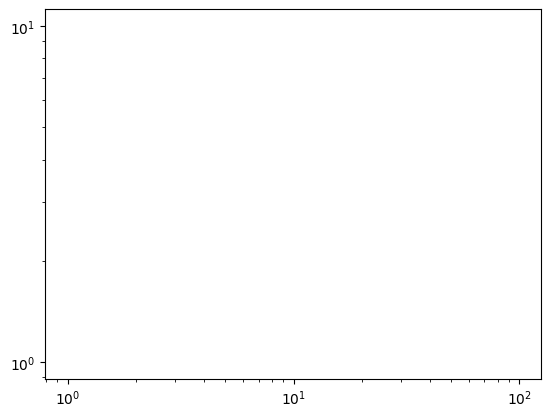

In [33]:
plt.loglog(allevatau[0][:,-1], 'b.-') # plot eigenvalues in decending order, shouldn't the first be 1 
plt.loglog(allevatau[1][:,-1], 'r.-')

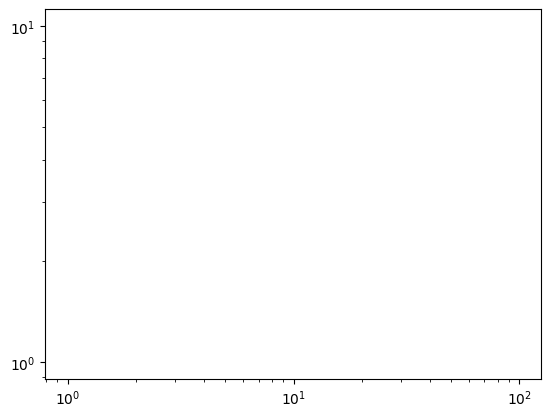

In [34]:
plt.loglog(allevatau[0][:,-1], 'b.-') # plot eigenvalues in decending order, shouldn't the first be 1 
plt.loglog(allevatau[1][:,-1], 'r.-')

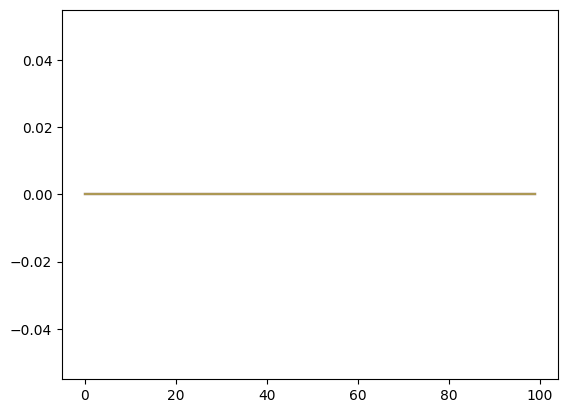

In [35]:
NUM_EVA = 10
for i in range(1, NUM_EVA):
    plt.plot(allevatau[0,:,-i], label=fr'$\lambda_{i}', alpha=0.5) # plot eigenvalues in decending order, shouldn't the first be 1 
    #plt.loglog(allevatau[0,:,-i], label=fr'$\lambda_{i}', alpha=0.5) # plot eigenvalues in decending order, shouldn't the first be 1 


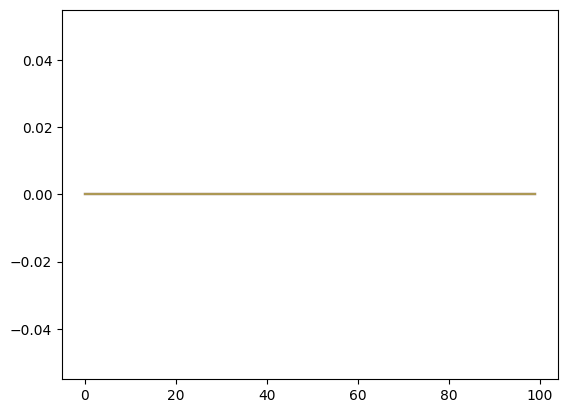

In [36]:
NUM_EVA = 10
for i in range(1, NUM_EVA):
    plt.plot(allevatau[1,:,-i], label=fr'$\lambda_{i}', alpha=0.5) # plot eigenvalues in decending order, shouldn't the first be 1 
    #plt.loglog(allevatau[1,:,-i], label=fr'$\lambda_{i}', alpha=0.5) # plot eigenvalues in decending order, shouldn't the first be 1 


In [ ]:
# Sample the scalar product (usign X0)
np.mean(ev1)

In [44]:
# the alleve are the coefficients for linearly combining the soap components
def scalar_product(v1,v2):
    f1 = np.sum(v1[0]*soapsum[0])
    f2 = np.sum(v2[0]*soapsum[0])
    
np.sqrt([ np.mean(allevetau[0][:,-i], allevetau[0][:,-j]) for i in range(10) for j in range(10)])

TypeError: only integer scalar arrays can be converted to a scalar index

[0. 0. 0. ... 0. 0. 0.]


 ...]

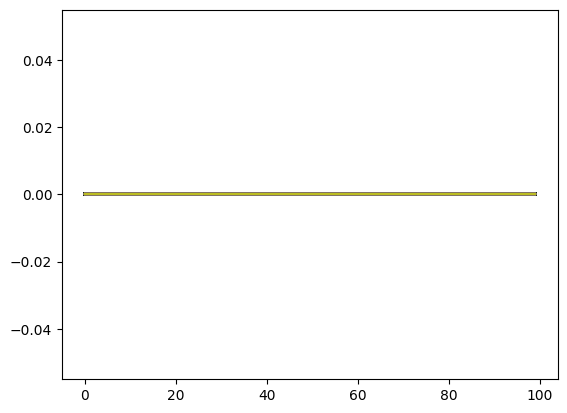

In [45]:
print((allevatau[0][-1]))
plt.plot(allevetau[0][:,-1])

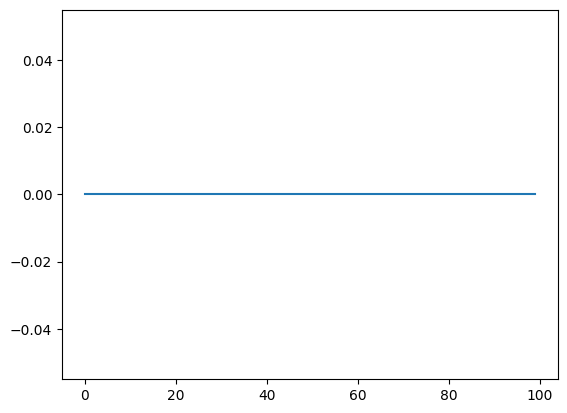

In [46]:
plt.plot(allevatau[0][:,-1])

 ...]

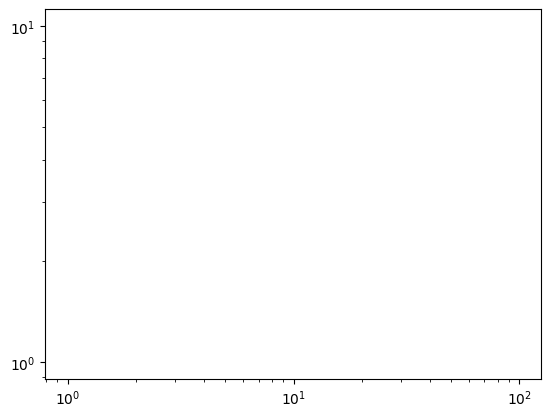

In [47]:
plt.loglog(allevatau[0][::-1], 'b.-') # plot eigenvalues in decending order, shouldn't the first be 1 
plt.loglog(allevatau[1][::-1], 'r.-')

 ...]

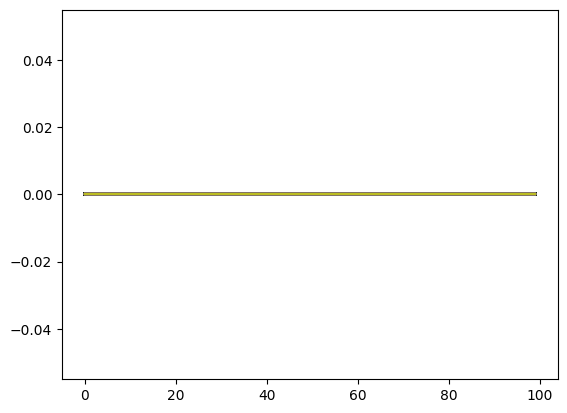

In [48]:
plt.plot(allevetau[0][:,-1])

In [ ]:
u0 = eigvec[:,-4]

In [49]:
c00=np.einsum("ijab,a,b->ij", corrcc, u0, u0)

NameError: name 'u0' is not defined

In [50]:
plt.plot(c00[0])

NameError: name 'c00' is not defined

In [ ]:
alleve[0].shape
new_soap[ige].shape

In [52]:
npca = 40
trj_act = np.zeros((len(frames),len(atomsel),npca) )
for fidx, frame in tqdm(enumerate(frames)):
    rho2i = calculator.compute(frame) # , selected_keys=selection)
    rho2i = rho2i.keys_to_samples(["center_type"]).keys_to_properties(
        ["neighbor_1_type", "neighbor_2_type"]
    )
    new_soap = rho2i.block(0).values[atomsel]
    trj_act[fidx] = np.vstack([
        np.einsum("ba,ib->ia", allevetau[...,::-1][0,:,:npca], new_soap[ige]),
        np.einsum("ba,ib->ia", allevetau[...,::-1][1,:,:npca], new_soap[ite])    
    ])

0it [00:00, ?it/s]


ValueError: operand has more dimensions than subscripts given in einstein sum, but no '...' ellipsis provided to broadcast the extra dimensions.

In [ ]:
trj_act.shape

In [ ]:
trj_act[:,0,0]

In [ ]:
plt.plot(trj_act[:,-1,0])
plt.plot(trj_act[:,-1,1])

In [ ]:
plt.scatter(trj_act[:,0,0], trj_act[:,0,1], c=np.arange(len(trj_act)), linestyle='-')

# Running averaging

In [ ]:
stride = 4
frames = ase.io.read("ramp_up.pos_0.extxyz", "1000:")[::stride] + ase.io.read("ramp_down.pos_0.extxyz", ":-500")[::stride]
for f in frames:
    f.wrap()

In [ ]:
len(frames)

In [ ]:
# hypers for evaluating features
hypers = {
    "cutoff": {"radius": 4, "smoothing": {"type": "ShiftedCosine", "width": 8}},
    "density": {"type": "Gaussian", "width": 2.0},
    "basis": {
        "type": "TensorProduct",
        "max_angular": 6,
        "radial": {"type": "Gto", "max_radial": 4},
    },
}
# gets only Te-centered features
selection = Labels(
    names=["center_type"],
    values=np.array([[52]], dtype=np.int32),
)
calculator = featomic.SoapPowerSpectrum(**hypers)

In [ ]:
rho2i_0 = calculator.compute(frames[0]) # , selected_keys=selection)
rho2i_0 = rho2i_0.keys_to_samples(["center_type"]).keys_to_properties(
    ["neighbor_1_type", "neighbor_2_type"]
)
rho2i_values = rho2i_0.block(0).values
print(rho2i_values.shape)

In [ ]:
maxlag=50
atomsel=np.arange(0,len(frames[0]),32) # selects only a few atoms so it fits into memory
ige = np.arange(len(atomsel)//2)
ite = ige+(len(atomsel)//2)

In [ ]:
kernel = 1-np.abs(np.arange(maxlag)-maxlag/2)*2/maxlag
kernel /= kernel.sum()
plt.plot(kernel)

In [ ]:
buffer = np.zeros((len(atomsel), maxlag, rho2i_values.shape[1]))
avgcov = np.zeros((2, rho2i_values.shape[1], rho2i_values.shape[1],))
avgcovta = np.zeros((2, rho2i_values.shape[1], rho2i_values.shape[1],))
soapsum = np.zeros((2 ,rho2i_values.shape[1],))

In [ ]:
nsmp = 0
for fidx, frame in tqdm(enumerate(frames)):
    rho2i = calculator.compute(frame) # , selected_keys=selection)
    rho2i = rho2i.keys_to_samples(["center_type"]).keys_to_properties(
        ["neighbor_1_type", "neighbor_2_type"]
    )
    new_soap = rho2i.block(0).values[atomsel]
    
    if fidx>=maxlag:
        first = buffer[:,fidx%maxlag]
        roll_kernel = np.roll(kernel, -fidx%maxlag)
        # computes a contribution to the correlation function
        # the buffer contains data from fidx-maxlag to fidx. add a forward ACF        
        avg_soap = np.einsum("j,ija->ia", roll_kernel, buffer) # getting time averaged SOAP
        soapsum[0] += avg_soap[ige].sum(axis=0) # sum over atoms 
        soapsum[1] += avg_soap[ite].sum(axis=0) # sum over atoms       
        # ge and te averaged covariance with no time lag (PCA, no tICA)
        avgcov[0] += np.einsum("ia,ib->ab", new_soap[ige], new_soap[ige]) # summing over atoms 
        avgcov[1] += np.einsum("ia,ib->ab", new_soap[ite], new_soap[ite])
        avgcovta[0] += np.einsum("ia,ib->ab", avg_soap[ige], avg_soap[ige]) # summing over atoms 
        avgcovta[1] += np.einsum("ia,ib->ab", avg_soap[ite], avg_soap[ite])
        nsmp += len(ige)        
        
    buffer[:,fidx%maxlag] = new_soap

In [ ]:
# autocorrelation matrix - remove mean
#avgcc = avgcov/nsmp - soapsum[:, :, None]* soapsum[:, None, :]/(nsmp**2)
avgcc = avgcov/nsmp - soapsum[:, :, None]* soapsum[:, None, :]/(nsmp**2)
avgccta = avgcovta/nsmp - soapsum[:, :, None]* soapsum[:, None, :]/(nsmp**2)

In [ ]:
# much more symmetric than the estimated covariance matrix
print(avgcc.shape)
vmax = np.max(np.abs(avgcc[0]))
cax = plt.matshow(avgcc[0], cmap='RdBu_r', vmin=-vmax, vmax=vmax)
plt.colorbar(cax)

In [ ]:
print(avgccta.shape)
vmax = np.max(np.abs(avgccta[0]))
cax = plt.matshow(avgccta[0], cmap='RdBu_r', vmin=-vmax, vmax=vmax)
plt.colorbar(cax)

In [ ]:
"""alleva, alleve = [None, None], [None, None]
for i in range(2):
    alleva[i], alleve[i] = sp.linalg.eigh(0.5*(avgcc[i]+avgcc[i].T))
alleva = np.array(alleva)
alleve = np.array(alleve)"""

allevata, alleveta = [None, None], [None, None]
for i in range(2):
    allevata[i], alleveta[i] = sp.linalg.eigh(0.5*(avgccta[i]+avgccta[i].T))
allevata = np.array(allevata)
alleveta = np.array(alleveta)

In [ ]:
plt.loglog(allevata[0][::-1], 'b.-')
plt.loglog(allevata[1][::-1], 'r.-')

NUM_EVA = 10
for i in range(1, NUM_EVA):
    plt.plot(allevata[0,:,-i], label=fr'$\lambda_{i}', alpha=0.5) # plot eigenvalues in decending order, shouldn't the first be 1 
    #plt.loglog(allevatau[0,:,-i], label=fr'$\lambda_{i}', alpha=0.5) # plot eigenvalues in decending order, shouldn't the first be 1 


In [ ]:
plt.loglog(alleva[0][::-1], 'b.-')
plt.loglog(alleva[1][::-1], 'r.-')

NUM_EVA = 10
for i in range(1, NUM_EVA):
    plt.plot(allevatau[0,:,-i], label=fr'$\lambda_{i}', alpha=0.5) # plot eigenvalues in decending order, shouldn't the first be 1 
    #plt.loglog(allevatau[0,:,-i], label=fr'$\lambda_{i}', alpha=0.5) # plot eigenvalues in decending order, shouldn't the first be 1 


In [ ]:
print(avg_soap.shape)
print(new_soap.shape)
#plt.plot(alleve[0][:,-1])

In [ ]:
npca = 40
trj_avg = np.zeros((len(frames),len(atomsel),npca) )
for fidx, frame in tqdm(enumerate(frames)):
    rho2i = calculator.compute(frame) # , selected_keys=selection)
    rho2i = rho2i.keys_to_samples(["center_type"]).keys_to_properties(
        ["neighbor_1_type", "neighbor_2_type"]
    )
    new_soap = rho2i.block(0).values[atomsel]
    trj_avg[fidx] = np.vstack([
        np.einsum("ba,ib->ia", alleveta[...,::-1][0,:,:npca], new_soap[ige]),
        np.einsum("ba,ib->ia", alleveta[...,::-1][1,:,:npca], new_soap[ite])    
    ])

In [ ]:
plt.plot(trj_avg[:,-1,0])
plt.plot(trj_avg[:,-1,1])

In [ ]:
plt.scatter(trj_avg[:,0,0], trj_avg[:,0,1], c=np.arange(len(trj_avg)), linestyle='-')

### LDA

In [12]:
maxlag=50
atomsel=np.arange(0,len(frames[0]),32) # selects only a few atoms so it fits into memory
ige = np.arange(len(atomsel)//2)
ite = ige+(len(atomsel)//2)

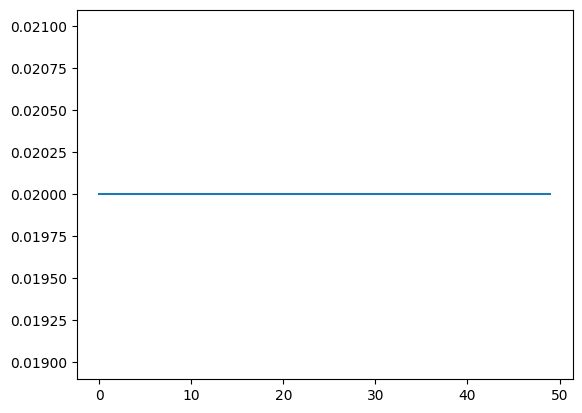

In [13]:
#kernel = 1-np.abs(np.arange(maxlag)-maxlag/2)*2/maxlag
kernel = np.ones(maxlag)
kernel /= kernel.sum()
plt.plot(kernel)

In [14]:
buffer = np.zeros((len(atomsel), maxlag, rho2i_values.shape[1]))
avgcov = np.zeros((2, rho2i_values.shape[1], rho2i_values.shape[1],))
avgcovta = np.zeros((2, rho2i_values.shape[1], rho2i_values.shape[1],))
soapsum = np.zeros((2 ,rho2i_values.shape[1],))
mean = np.zeros((2, rho2i_values.shape[1]))

In [ ]:
nsmp = 0
for fidx, frame in tqdm(enumerate(frames)):
    rho2i = calculator.compute(frame) # , selected_keys=selection)
    rho2i = rho2i.keys_to_samples(["center_type"]).keys_to_properties(
        ["neighbor_1_type", "neighbor_2_type"]
    )
    new_soap = rho2i.block(0).values[atomsel]
    
    if fidx>=maxlag:
        first = buffer[:,fidx%maxlag]
        roll_kernel = np.roll(kernel, -fidx%maxlag)
        # computes a contribution to the correlation function
        # the buffer contains data from fidx-maxlag to fidx. add a forward ACF        
        avg_soap = np.einsum("j,ija->ia", roll_kernel, buffer) # getting time averaged SOAP
        soapsum[0] += avg_soap[ige].sum(axis=0) # sum over atoms 
        soapsum[1] += avg_soap[ite].sum(axis=0) # sum over atoms       
        # ge and te averaged covariance with no time lag (PCA, no tICA)
        
        # get within covariances for both classes A, B
        avgcov[0] += np.einsum("ia,ib->ab", new_soap[ige], new_soap[ige]) # summing over atoms i
        avgcov[1] += np.einsum("ia,ib->ab", new_soap[ite], new_soap[ite])
        avgcovta[0] += np.einsum("ia,ib->ab", avg_soap[ige], avg_soap[ige]) # summing over atoms i
        avgcovta[1] += np.einsum("ia,ib->ab", avg_soap[ite], avg_soap[ite])
        # get class means for A, B
        mean[0] += np.mean(avg_soap[ige], axis=0) # summing over atoms
        mean[1] += np.mean(avg_soap[ite], axis=0)
        nsmp += len(ige)        
        
    buffer[:,fidx%maxlag] = new_soap

# Chemiscope the f**k out of it

In [ ]:
cs=chemiscope.show(frames,
                properties={
                    "act[0]": trj_act[...,0].flatten(),
                    "act[1]": trj_act[...,1].flatten(),
                    "avg[0]": trj_avg[...,0].flatten(),
                    "avg[1]": trj_avg[...,1].flatten(),
                },
                environments = [[i,j,4] for i in range(len(frames)) for j in atomsel],
                settings=chemiscope.quick_settings(periodic=True, trajectory=True, target="atom", map_settings={"joinPoints": False})
               )

In [ ]:
cs.settings

In [ ]:
cs

In [ ]:
cs.save("gete-avg-test.chemiscope.json")